<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_for_odd_sized_images_ver16%20int20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [0]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
#os._exit(0)

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([100000,28,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 1000):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage1
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*1000 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 600])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
def load_large_data5656():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
X_trainlarge = load_large_data()

In [0]:
X_trainlarge5656 = load_large_data5656()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  if (datasetname == 3):   
     X_train = X_trainlarge
  if (datasetname == 4):   
     X_train = X_trainlarge5656

  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
  #  print("-- Discriminator -- ")
   # model.summary()
    return model

In [0]:
def build_discriminator2856(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def save_imgs_all(generator1, generator2, generator3, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator1.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()
    
    gen_imgs = generator2.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    #Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
   # Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)
    X_train5656 = None
    
    if modeltotrain == 3:
          X_train5656 = load_databydatasetname(3)

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
        
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              noise2 = copy.deepcopy(noise1)
              fake_images3 = mergedmodel.predict(noise2)
              fake_labels3 = np.zeros((half_batch, 1))    
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)
              print("real images")
              print(real_images.shape)

            X_train = X_trainlarge
            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)            
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs_all(generator1, generator2, mergedmodel,  epoch, batch)
            #if batch % 101 == 0:
                 #save_imgs(generator2, epoch, batch)
            #if batch % 102 == 0:
                 #save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNandriNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 56, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    for obj1 in outputs:
      print(type(obj1))
      print(obj1.shape)
        
    mergedlayer = Concatenate(axis=2)(outputs)
    ##x = merge([lstm_out, auxiliary_input], mode='concat')
   ## output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
  #  mergedlayer = merge([generator1, generator2], mode='concat', concat_axis=1)
  
   #mergedlayer = merge([out1, out], mode='concat', concat_axis=1)
#contact axis can be -1 to 0 , 1 for inception , 2 , 3 or remove it
  #  mergedlayer = merge([generator1, generator1])

    print('merge layers')
    print(out1.shape)
    print(out.shape)
    print(mergedlayer.shape)

  

    
    
    mergedmodel = Model(z, mergedlayer)
    
    discriminator.trainable = False
    real = discriminator(mergedlayer)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
      generator1.load_weights('my_model_weights_mnist.h5')
      #generator2.load_weights('my_model_weights_mnist.h5')
      #generator1 = load_model('generator2fmnist.h5')
      #generator2 = load_model('generator2fmnist.h5')
      

    generator1.trainable = False
    
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    plotamodel(mergedmodel)
   # plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 3 ,  loadpretrainedweights=True)




    
    

    


In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnist.h5

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
plotamodel(discriminator)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=10, modeltotrain=1)

Epoch 4 Batch 1391/1875 [D loss: 0.033446, acc.: 100.00%] [G loss: 5.847323]
Epoch 4 Batch 1392/1875 [D loss: 0.010151, acc.: 100.00%] [G loss: 9.808696]
Epoch 4 Batch 1393/1875 [D loss: 0.001600, acc.: 100.00%] [G loss: 7.792210]
Epoch 4 Batch 1394/1875 [D loss: 0.008549, acc.: 100.00%] [G loss: 7.061041]
Epoch 4 Batch 1395/1875 [D loss: 0.010305, acc.: 100.00%] [G loss: 8.216191]
Epoch 4 Batch 1396/1875 [D loss: 0.009445, acc.: 100.00%] [G loss: 8.359489]
Epoch 4 Batch 1397/1875 [D loss: 0.013773, acc.: 100.00%] [G loss: 7.192054]
Epoch 4 Batch 1398/1875 [D loss: 0.023425, acc.: 100.00%] [G loss: 8.669613]
Epoch 4 Batch 1399/1875 [D loss: 0.009294, acc.: 100.00%] [G loss: 8.892362]
Epoch 4 Batch 1400/1875 [D loss: 0.100807, acc.: 93.75%] [G loss: 7.729729]


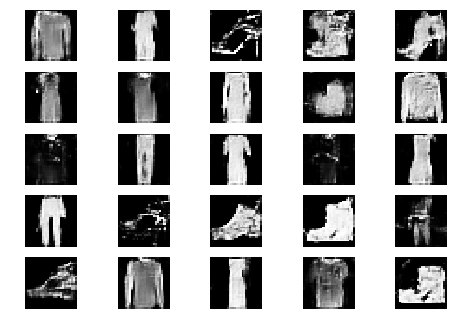

Epoch 4 Batch 1401/1875 [D loss: 0.020046, acc.: 100.00%] [G loss: 8.575586]
Epoch 4 Batch 1402/1875 [D loss: 0.063191, acc.: 93.75%] [G loss: 10.362231]
Epoch 4 Batch 1403/1875 [D loss: 0.033409, acc.: 100.00%] [G loss: 10.676385]
Epoch 4 Batch 1404/1875 [D loss: 0.082735, acc.: 93.75%] [G loss: 8.322836]
Epoch 4 Batch 1405/1875 [D loss: 0.052257, acc.: 96.88%] [G loss: 6.032527]
Epoch 4 Batch 1406/1875 [D loss: 0.048111, acc.: 100.00%] [G loss: 6.463036]
Epoch 4 Batch 1407/1875 [D loss: 0.077985, acc.: 96.88%] [G loss: 9.653526]
Epoch 4 Batch 1408/1875 [D loss: 0.032703, acc.: 100.00%] [G loss: 9.073110]
Epoch 4 Batch 1409/1875 [D loss: 0.028638, acc.: 100.00%] [G loss: 7.748639]
Epoch 4 Batch 1410/1875 [D loss: 0.108687, acc.: 96.88%] [G loss: 10.077220]
Epoch 4 Batch 1411/1875 [D loss: 0.018051, acc.: 100.00%] [G loss: 9.061224]
Epoch 4 Batch 1412/1875 [D loss: 0.007161, acc.: 100.00%] [G loss: 9.475382]
Epoch 4 Batch 1413/1875 [D loss: 0.006948, acc.: 100.00%] [G loss: 9.254211]
E

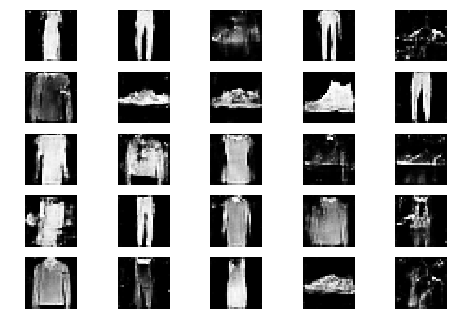

Epoch 4 Batch 1415/1875 [D loss: 0.077275, acc.: 96.88%] [G loss: 7.382630]
Epoch 4 Batch 1416/1875 [D loss: 0.022831, acc.: 100.00%] [G loss: 7.612095]
Epoch 4 Batch 1417/1875 [D loss: 0.042485, acc.: 100.00%] [G loss: 8.088722]
Epoch 4 Batch 1418/1875 [D loss: 0.003858, acc.: 100.00%] [G loss: 10.585255]
Epoch 4 Batch 1419/1875 [D loss: 0.018907, acc.: 100.00%] [G loss: 10.114860]
Epoch 4 Batch 1420/1875 [D loss: 0.101791, acc.: 93.75%] [G loss: 8.236942]
Epoch 4 Batch 1421/1875 [D loss: 0.139031, acc.: 90.62%] [G loss: 9.190142]
Epoch 4 Batch 1422/1875 [D loss: 0.001394, acc.: 100.00%] [G loss: 9.945915]
Epoch 4 Batch 1423/1875 [D loss: 0.006761, acc.: 100.00%] [G loss: 11.283437]
Epoch 4 Batch 1424/1875 [D loss: 0.098799, acc.: 96.88%] [G loss: 9.376265]
Epoch 4 Batch 1425/1875 [D loss: 0.068561, acc.: 96.88%] [G loss: 9.253169]
Epoch 4 Batch 1426/1875 [D loss: 0.074070, acc.: 96.88%] [G loss: 9.018452]
Epoch 4 Batch 1427/1875 [D loss: 0.047440, acc.: 96.88%] [G loss: 7.000357]
Epo

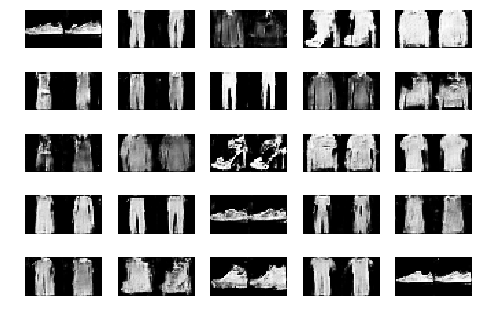

Epoch 4 Batch 1429/1875 [D loss: 0.162715, acc.: 93.75%] [G loss: 9.002912]
Epoch 4 Batch 1430/1875 [D loss: 0.007245, acc.: 100.00%] [G loss: 11.223017]
Epoch 4 Batch 1431/1875 [D loss: 0.109729, acc.: 93.75%] [G loss: 8.735168]
Epoch 4 Batch 1432/1875 [D loss: 0.020438, acc.: 100.00%] [G loss: 4.939709]
Epoch 4 Batch 1433/1875 [D loss: 0.010335, acc.: 100.00%] [G loss: 8.235205]
Epoch 4 Batch 1434/1875 [D loss: 0.024897, acc.: 100.00%] [G loss: 8.775345]
Epoch 4 Batch 1435/1875 [D loss: 0.012360, acc.: 100.00%] [G loss: 8.996788]
Epoch 4 Batch 1436/1875 [D loss: 0.038470, acc.: 96.88%] [G loss: 7.364125]
Epoch 4 Batch 1437/1875 [D loss: 0.015319, acc.: 100.00%] [G loss: 8.438379]
Epoch 4 Batch 1438/1875 [D loss: 0.001365, acc.: 100.00%] [G loss: 7.243096]
Epoch 4 Batch 1439/1875 [D loss: 0.134617, acc.: 90.62%] [G loss: 8.571119]
Epoch 4 Batch 1440/1875 [D loss: 0.012226, acc.: 100.00%] [G loss: 9.307267]
Epoch 4 Batch 1441/1875 [D loss: 0.141478, acc.: 90.62%] [G loss: 6.541420]
Epo

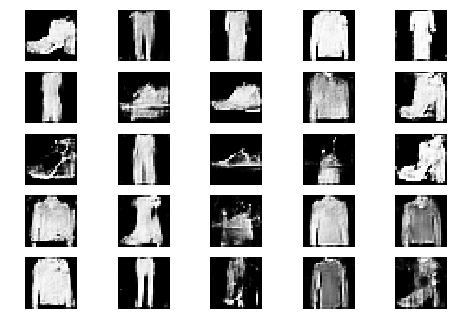

Epoch 4 Batch 1501/1875 [D loss: 0.147772, acc.: 96.88%] [G loss: 6.649107]
Epoch 4 Batch 1502/1875 [D loss: 0.034413, acc.: 96.88%] [G loss: 8.458216]
Epoch 4 Batch 1503/1875 [D loss: 0.002803, acc.: 100.00%] [G loss: 9.251865]
Epoch 4 Batch 1504/1875 [D loss: 0.056665, acc.: 96.88%] [G loss: 8.817369]
Epoch 4 Batch 1505/1875 [D loss: 0.007467, acc.: 100.00%] [G loss: 10.479201]
Epoch 4 Batch 1506/1875 [D loss: 0.001613, acc.: 100.00%] [G loss: 10.535385]
Epoch 4 Batch 1507/1875 [D loss: 0.019189, acc.: 100.00%] [G loss: 9.886316]
Epoch 4 Batch 1508/1875 [D loss: 0.003215, acc.: 100.00%] [G loss: 8.317095]
Epoch 4 Batch 1509/1875 [D loss: 0.002530, acc.: 100.00%] [G loss: 8.396479]
Epoch 4 Batch 1510/1875 [D loss: 0.095144, acc.: 96.88%] [G loss: 8.396832]
Epoch 4 Batch 1511/1875 [D loss: 0.203641, acc.: 96.88%] [G loss: 8.354081]
Epoch 4 Batch 1512/1875 [D loss: 0.032943, acc.: 100.00%] [G loss: 10.730457]
Epoch 4 Batch 1513/1875 [D loss: 0.014621, acc.: 100.00%] [G loss: 11.655717]


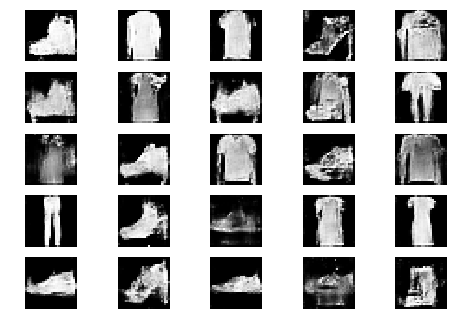

Epoch 4 Batch 1516/1875 [D loss: 0.075803, acc.: 96.88%] [G loss: 6.058967]
Epoch 4 Batch 1517/1875 [D loss: 0.103530, acc.: 93.75%] [G loss: 9.426550]
Epoch 4 Batch 1518/1875 [D loss: 0.048942, acc.: 96.88%] [G loss: 10.711705]
Epoch 4 Batch 1519/1875 [D loss: 0.054203, acc.: 96.88%] [G loss: 7.799799]
Epoch 4 Batch 1520/1875 [D loss: 0.006502, acc.: 100.00%] [G loss: 9.844362]
Epoch 4 Batch 1521/1875 [D loss: 0.058559, acc.: 96.88%] [G loss: 10.814530]
Epoch 4 Batch 1522/1875 [D loss: 0.019269, acc.: 100.00%] [G loss: 10.528902]
Epoch 4 Batch 1523/1875 [D loss: 0.034334, acc.: 96.88%] [G loss: 8.656029]
Epoch 4 Batch 1524/1875 [D loss: 0.003705, acc.: 100.00%] [G loss: 8.053133]
Epoch 4 Batch 1525/1875 [D loss: 0.008844, acc.: 100.00%] [G loss: 8.709578]
Epoch 4 Batch 1526/1875 [D loss: 0.008572, acc.: 100.00%] [G loss: 8.942720]
Epoch 4 Batch 1527/1875 [D loss: 0.002306, acc.: 100.00%] [G loss: 7.612817]
Epoch 4 Batch 1528/1875 [D loss: 0.107775, acc.: 90.62%] [G loss: 8.840384]
Epo

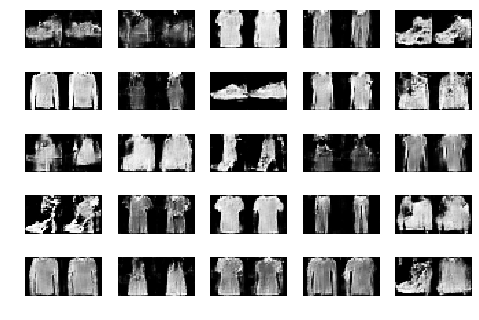

Epoch 4 Batch 1531/1875 [D loss: 0.015412, acc.: 100.00%] [G loss: 8.775618]
Epoch 4 Batch 1532/1875 [D loss: 0.070102, acc.: 96.88%] [G loss: 8.684132]
Epoch 4 Batch 1533/1875 [D loss: 0.116308, acc.: 93.75%] [G loss: 7.372013]
Epoch 4 Batch 1534/1875 [D loss: 0.043874, acc.: 96.88%] [G loss: 8.351363]
Epoch 4 Batch 1535/1875 [D loss: 0.034611, acc.: 100.00%] [G loss: 8.286801]
Epoch 4 Batch 1536/1875 [D loss: 0.011145, acc.: 100.00%] [G loss: 8.346266]
Epoch 4 Batch 1537/1875 [D loss: 0.006822, acc.: 100.00%] [G loss: 10.001457]
Epoch 4 Batch 1538/1875 [D loss: 0.033103, acc.: 96.88%] [G loss: 9.046618]
Epoch 4 Batch 1539/1875 [D loss: 0.002094, acc.: 100.00%] [G loss: 9.200655]
Epoch 4 Batch 1540/1875 [D loss: 0.009645, acc.: 100.00%] [G loss: 8.953691]
Epoch 4 Batch 1541/1875 [D loss: 0.003938, acc.: 100.00%] [G loss: 8.084247]
Epoch 4 Batch 1542/1875 [D loss: 0.012814, acc.: 100.00%] [G loss: 8.715017]
Epoch 4 Batch 1543/1875 [D loss: 0.036098, acc.: 96.88%] [G loss: 10.739111]
Ep

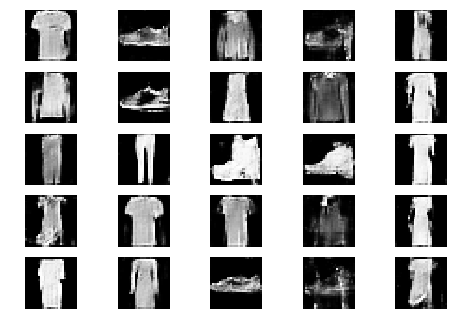

Epoch 4 Batch 1601/1875 [D loss: 0.020752, acc.: 100.00%] [G loss: 8.911613]
Epoch 4 Batch 1602/1875 [D loss: 0.014651, acc.: 100.00%] [G loss: 9.501529]
Epoch 4 Batch 1603/1875 [D loss: 0.040255, acc.: 100.00%] [G loss: 9.471615]
Epoch 4 Batch 1604/1875 [D loss: 0.011794, acc.: 100.00%] [G loss: 8.124266]
Epoch 4 Batch 1605/1875 [D loss: 0.006169, acc.: 100.00%] [G loss: 10.305948]
Epoch 4 Batch 1606/1875 [D loss: 0.049182, acc.: 96.88%] [G loss: 8.295473]
Epoch 4 Batch 1607/1875 [D loss: 0.013858, acc.: 100.00%] [G loss: 6.604376]
Epoch 4 Batch 1608/1875 [D loss: 0.004743, acc.: 100.00%] [G loss: 8.636321]
Epoch 4 Batch 1609/1875 [D loss: 0.014216, acc.: 100.00%] [G loss: 8.452457]
Epoch 4 Batch 1610/1875 [D loss: 0.018779, acc.: 100.00%] [G loss: 8.715136]
Epoch 4 Batch 1611/1875 [D loss: 0.045969, acc.: 96.88%] [G loss: 9.151232]
Epoch 4 Batch 1612/1875 [D loss: 0.023246, acc.: 100.00%] [G loss: 9.612643]
Epoch 4 Batch 1613/1875 [D loss: 0.050649, acc.: 96.88%] [G loss: 8.181723]
E

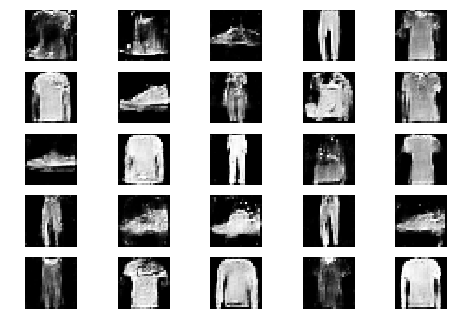

Epoch 4 Batch 1617/1875 [D loss: 0.010660, acc.: 100.00%] [G loss: 9.235918]
Epoch 4 Batch 1618/1875 [D loss: 0.059113, acc.: 96.88%] [G loss: 7.966346]
Epoch 4 Batch 1619/1875 [D loss: 0.011137, acc.: 100.00%] [G loss: 8.890018]
Epoch 4 Batch 1620/1875 [D loss: 0.005795, acc.: 100.00%] [G loss: 9.076993]
Epoch 4 Batch 1621/1875 [D loss: 0.012485, acc.: 100.00%] [G loss: 7.833580]
Epoch 4 Batch 1622/1875 [D loss: 0.122967, acc.: 96.88%] [G loss: 8.707733]
Epoch 4 Batch 1623/1875 [D loss: 0.092487, acc.: 96.88%] [G loss: 10.158545]
Epoch 4 Batch 1624/1875 [D loss: 0.007634, acc.: 100.00%] [G loss: 9.229340]
Epoch 4 Batch 1625/1875 [D loss: 0.021106, acc.: 100.00%] [G loss: 9.396959]
Epoch 4 Batch 1626/1875 [D loss: 0.093987, acc.: 96.88%] [G loss: 8.403687]
Epoch 4 Batch 1627/1875 [D loss: 0.104365, acc.: 96.88%] [G loss: 7.901949]
Epoch 4 Batch 1628/1875 [D loss: 0.143145, acc.: 93.75%] [G loss: 7.270503]
Epoch 4 Batch 1629/1875 [D loss: 0.126569, acc.: 96.88%] [G loss: 7.628019]
Epoch

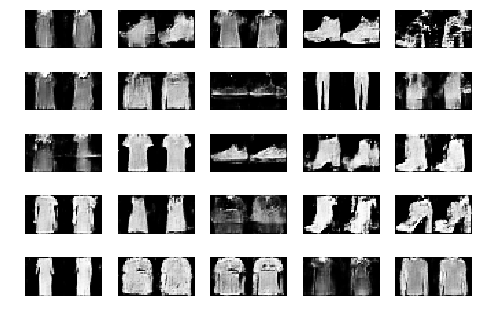

Epoch 4 Batch 1633/1875 [D loss: 0.108614, acc.: 93.75%] [G loss: 6.798203]
Epoch 4 Batch 1634/1875 [D loss: 0.018565, acc.: 100.00%] [G loss: 7.400105]
Epoch 4 Batch 1635/1875 [D loss: 0.012592, acc.: 100.00%] [G loss: 7.286058]
Epoch 4 Batch 1636/1875 [D loss: 0.117466, acc.: 93.75%] [G loss: 7.912209]
Epoch 4 Batch 1637/1875 [D loss: 0.136113, acc.: 96.88%] [G loss: 9.170502]
Epoch 4 Batch 1638/1875 [D loss: 0.181113, acc.: 96.88%] [G loss: 6.770753]
Epoch 4 Batch 1639/1875 [D loss: 0.015791, acc.: 100.00%] [G loss: 8.316644]
Epoch 4 Batch 1640/1875 [D loss: 0.055478, acc.: 96.88%] [G loss: 7.765363]
Epoch 4 Batch 1641/1875 [D loss: 0.074348, acc.: 96.88%] [G loss: 8.239462]
Epoch 4 Batch 1642/1875 [D loss: 0.118277, acc.: 90.62%] [G loss: 8.189384]
Epoch 4 Batch 1643/1875 [D loss: 0.010640, acc.: 100.00%] [G loss: 8.329260]
Epoch 4 Batch 1644/1875 [D loss: 0.053049, acc.: 96.88%] [G loss: 8.440170]
Epoch 4 Batch 1645/1875 [D loss: 0.113256, acc.: 96.88%] [G loss: 7.523537]
Epoch 4 

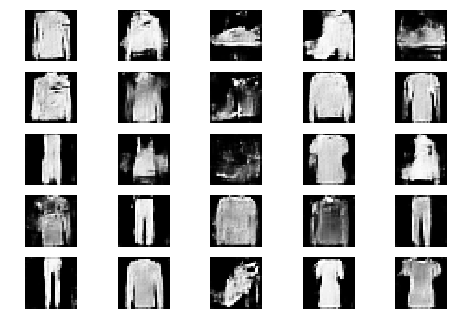

Epoch 4 Batch 1701/1875 [D loss: 0.001353, acc.: 100.00%] [G loss: 7.959191]
Epoch 4 Batch 1702/1875 [D loss: 0.012663, acc.: 100.00%] [G loss: 8.176836]
Epoch 4 Batch 1703/1875 [D loss: 0.011947, acc.: 100.00%] [G loss: 9.920401]
Epoch 4 Batch 1704/1875 [D loss: 0.000729, acc.: 100.00%] [G loss: 8.249767]
Epoch 4 Batch 1705/1875 [D loss: 0.069057, acc.: 100.00%] [G loss: 7.293755]
Epoch 4 Batch 1706/1875 [D loss: 0.013792, acc.: 100.00%] [G loss: 5.891284]
Epoch 4 Batch 1707/1875 [D loss: 0.003278, acc.: 100.00%] [G loss: 8.451200]
Epoch 4 Batch 1708/1875 [D loss: 0.018873, acc.: 100.00%] [G loss: 7.265932]
Epoch 4 Batch 1709/1875 [D loss: 0.049356, acc.: 96.88%] [G loss: 8.585835]
Epoch 4 Batch 1710/1875 [D loss: 0.093255, acc.: 96.88%] [G loss: 8.734026]
Epoch 4 Batch 1711/1875 [D loss: 0.003686, acc.: 100.00%] [G loss: 8.209224]
Epoch 4 Batch 1712/1875 [D loss: 0.012442, acc.: 100.00%] [G loss: 7.722412]
Epoch 4 Batch 1713/1875 [D loss: 0.018376, acc.: 100.00%] [G loss: 9.675249]
E

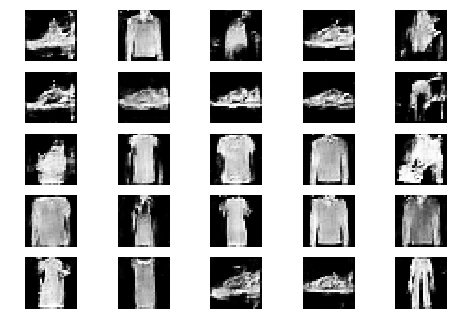

Epoch 4 Batch 1718/1875 [D loss: 0.042553, acc.: 96.88%] [G loss: 9.103666]
Epoch 4 Batch 1719/1875 [D loss: 0.006980, acc.: 100.00%] [G loss: 8.637794]
Epoch 4 Batch 1720/1875 [D loss: 0.038029, acc.: 96.88%] [G loss: 9.239305]
Epoch 4 Batch 1721/1875 [D loss: 0.003274, acc.: 100.00%] [G loss: 10.516311]
Epoch 4 Batch 1722/1875 [D loss: 0.176681, acc.: 87.50%] [G loss: 8.514879]
Epoch 4 Batch 1723/1875 [D loss: 0.001186, acc.: 100.00%] [G loss: 10.654861]
Epoch 4 Batch 1724/1875 [D loss: 0.025019, acc.: 100.00%] [G loss: 8.545464]
Epoch 4 Batch 1725/1875 [D loss: 0.015801, acc.: 100.00%] [G loss: 9.673224]
Epoch 4 Batch 1726/1875 [D loss: 0.042343, acc.: 96.88%] [G loss: 7.448663]
Epoch 4 Batch 1727/1875 [D loss: 0.004157, acc.: 100.00%] [G loss: 9.502016]
Epoch 4 Batch 1728/1875 [D loss: 0.045089, acc.: 96.88%] [G loss: 6.681884]
Epoch 4 Batch 1729/1875 [D loss: 0.040263, acc.: 96.88%] [G loss: 7.911078]
Epoch 4 Batch 1730/1875 [D loss: 0.018375, acc.: 100.00%] [G loss: 8.227421]
Epo

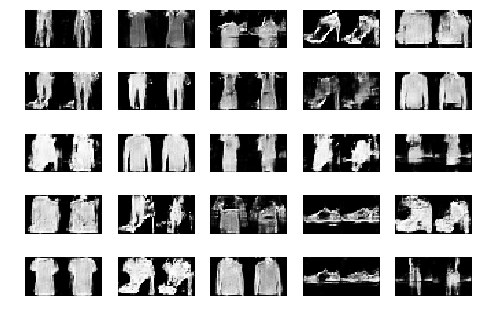

Epoch 4 Batch 1735/1875 [D loss: 0.081054, acc.: 96.88%] [G loss: 8.585125]
Epoch 4 Batch 1736/1875 [D loss: 0.032935, acc.: 100.00%] [G loss: 7.902831]
Epoch 4 Batch 1737/1875 [D loss: 0.013733, acc.: 100.00%] [G loss: 8.127943]
Epoch 4 Batch 1738/1875 [D loss: 0.033258, acc.: 100.00%] [G loss: 8.374837]
Epoch 4 Batch 1739/1875 [D loss: 0.078937, acc.: 96.88%] [G loss: 9.932731]
Epoch 4 Batch 1740/1875 [D loss: 0.026214, acc.: 96.88%] [G loss: 10.004232]
Epoch 4 Batch 1741/1875 [D loss: 0.041886, acc.: 100.00%] [G loss: 8.539724]
Epoch 4 Batch 1742/1875 [D loss: 0.017481, acc.: 100.00%] [G loss: 8.185799]
Epoch 4 Batch 1743/1875 [D loss: 0.014042, acc.: 100.00%] [G loss: 8.085124]
Epoch 4 Batch 1744/1875 [D loss: 0.014802, acc.: 100.00%] [G loss: 9.763405]
Epoch 4 Batch 1745/1875 [D loss: 0.049772, acc.: 96.88%] [G loss: 7.555442]
Epoch 4 Batch 1746/1875 [D loss: 0.030579, acc.: 96.88%] [G loss: 6.973050]
Epoch 4 Batch 1747/1875 [D loss: 0.005920, acc.: 100.00%] [G loss: 7.353980]
Epo

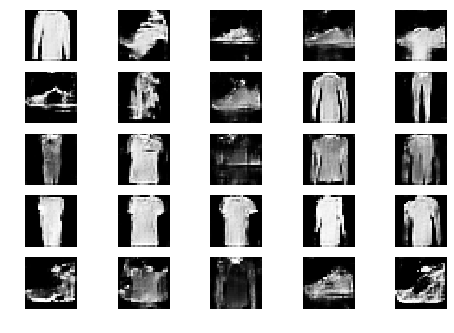

Epoch 4 Batch 1801/1875 [D loss: 0.022658, acc.: 100.00%] [G loss: 10.343618]
Epoch 4 Batch 1802/1875 [D loss: 0.021612, acc.: 100.00%] [G loss: 8.494661]
Epoch 4 Batch 1803/1875 [D loss: 0.010265, acc.: 100.00%] [G loss: 8.792215]
Epoch 4 Batch 1804/1875 [D loss: 0.001294, acc.: 100.00%] [G loss: 9.281056]
Epoch 4 Batch 1805/1875 [D loss: 0.062093, acc.: 96.88%] [G loss: 9.273994]
Epoch 4 Batch 1806/1875 [D loss: 0.002461, acc.: 100.00%] [G loss: 9.426531]
Epoch 4 Batch 1807/1875 [D loss: 0.003511, acc.: 100.00%] [G loss: 9.792955]
Epoch 4 Batch 1808/1875 [D loss: 0.048892, acc.: 96.88%] [G loss: 9.194332]
Epoch 4 Batch 1809/1875 [D loss: 0.169257, acc.: 96.88%] [G loss: 10.927363]
Epoch 4 Batch 1810/1875 [D loss: 0.018631, acc.: 100.00%] [G loss: 9.900807]
Epoch 4 Batch 1811/1875 [D loss: 0.006979, acc.: 100.00%] [G loss: 9.239458]
Epoch 4 Batch 1812/1875 [D loss: 0.005508, acc.: 100.00%] [G loss: 9.794851]
Epoch 4 Batch 1813/1875 [D loss: 0.144069, acc.: 96.88%] [G loss: 8.175827]
E

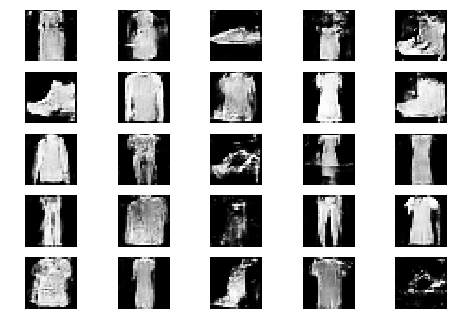

Epoch 4 Batch 1819/1875 [D loss: 0.023124, acc.: 100.00%] [G loss: 11.869981]
Epoch 4 Batch 1820/1875 [D loss: 0.050566, acc.: 96.88%] [G loss: 8.659013]
Epoch 4 Batch 1821/1875 [D loss: 0.004342, acc.: 100.00%] [G loss: 7.490049]
Epoch 4 Batch 1822/1875 [D loss: 0.006156, acc.: 100.00%] [G loss: 10.250694]
Epoch 4 Batch 1823/1875 [D loss: 0.001709, acc.: 100.00%] [G loss: 10.082563]
Epoch 4 Batch 1824/1875 [D loss: 0.009710, acc.: 100.00%] [G loss: 7.406534]
Epoch 4 Batch 1825/1875 [D loss: 0.021906, acc.: 100.00%] [G loss: 9.210311]
Epoch 4 Batch 1826/1875 [D loss: 0.007742, acc.: 100.00%] [G loss: 9.453907]
Epoch 4 Batch 1827/1875 [D loss: 0.022663, acc.: 100.00%] [G loss: 7.593220]
Epoch 4 Batch 1828/1875 [D loss: 0.014785, acc.: 100.00%] [G loss: 7.957685]
Epoch 4 Batch 1829/1875 [D loss: 0.030038, acc.: 96.88%] [G loss: 5.994383]
Epoch 4 Batch 1830/1875 [D loss: 0.012463, acc.: 100.00%] [G loss: 6.914584]
Epoch 4 Batch 1831/1875 [D loss: 0.005232, acc.: 100.00%] [G loss: 6.389251

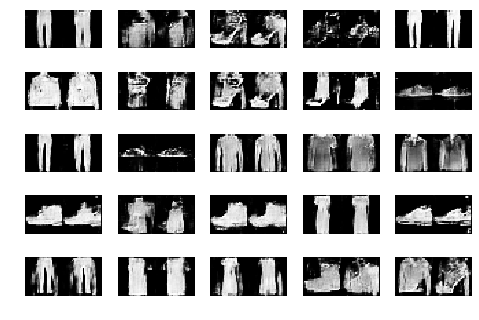

Epoch 4 Batch 1837/1875 [D loss: 0.001642, acc.: 100.00%] [G loss: 9.450865]
Epoch 4 Batch 1838/1875 [D loss: 0.037636, acc.: 96.88%] [G loss: 9.926306]
Epoch 4 Batch 1839/1875 [D loss: 0.022351, acc.: 100.00%] [G loss: 8.344770]
Epoch 4 Batch 1840/1875 [D loss: 0.053996, acc.: 96.88%] [G loss: 10.031005]
Epoch 4 Batch 1841/1875 [D loss: 0.003751, acc.: 100.00%] [G loss: 8.421322]
Epoch 4 Batch 1842/1875 [D loss: 0.017104, acc.: 100.00%] [G loss: 8.289670]
Epoch 4 Batch 1843/1875 [D loss: 0.010477, acc.: 100.00%] [G loss: 8.465501]
Epoch 4 Batch 1844/1875 [D loss: 0.024730, acc.: 100.00%] [G loss: 9.172216]
Epoch 4 Batch 1845/1875 [D loss: 0.002395, acc.: 100.00%] [G loss: 11.350759]
Epoch 4 Batch 1846/1875 [D loss: 0.103429, acc.: 96.88%] [G loss: 10.089354]
Epoch 4 Batch 1847/1875 [D loss: 0.011738, acc.: 100.00%] [G loss: 11.325380]
Epoch 4 Batch 1848/1875 [D loss: 0.007280, acc.: 100.00%] [G loss: 9.106787]
Epoch 4 Batch 1849/1875 [D loss: 0.117336, acc.: 96.88%] [G loss: 8.635714]

In [49]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=4, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 2 ,  loadpretrainedweights=True)




    
    

    


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=64, save_interval=1, modeltotrain = 3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=4, batch_size=64, save_interval=1, modeltotrain = 3)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=20, modeltotrain=3)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5
!rm -rf generator2fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator2fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')


In [0]:
generator2 = generator2.load_weights('generator1fminst.h5')




In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

